# **Importing depedencies**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
import csv
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from torch.autograd import Variable
import torch.optim as optim
import torchtext
from torchtext import data
from torchtext import vocab
from sklearn.decomposition import PCA
from sklearn import metrics
import warnings 
warnings.filterwarnings("ignore") # Removing warnings

# **Mounting drive**

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# **Reading the Dataset**

*Initializing the variables and filenames*

In [3]:
filename_train = "/content/gdrive/My Drive/Colab Notebooks/StumbleUpon Challenge/train.tsv"
filename_test = "/content/gdrive/My Drive/Colab Notebooks/StumbleUpon Challenge/test.tsv"

# Storing boilerplate text and numerical features seperately
# In numerical
bp_text_train = []
bp_text_test = []
labels_train = []
labels_test = []
numerical_features_train = []
numerical_features_test = []

*Parsing train.tsv*

In [4]:
# Collecting numerical features, labels and the boilerplate text seperately
with open(filename_train) as tsvfile:
    tsvreader = csv.reader(tsvfile, delimiter="\t")
    column_names = tsvreader.__next__()
    for row in tsvreader:
        bp_text_train.append(row[2][10:]) # Remove the 'title' occuring in the beginning
        labels_train.append(row[-1])
        numerical_features_train.append(row[4:-1])
print("train.tsv parsed")

train.tsv parsed


*Parsing test.csv*

In [5]:
# Collecting numerical features, labels and the boilerplate text seperately
with open(filename_test) as tsvfile:
    tsvreader = csv.reader(tsvfile, delimiter="\t")
    column_names = tsvreader.__next__()
    for row in tsvreader:
        bp_text_test.append(row[2][10:]) # Remove the 'title' occuring in the beginning
        numerical_features_test.append(row[4:])
print("test.tsv parsed")

test.tsv parsed


# **Performing train-validation split**

*Performing 80:20 split in Train set*

In [6]:
train_data=[]
train_labels=[]
val_data=[]
val_labels=[]
test_data = []

# Performing 80:20 split
split_factor = 0.8
split_index = int(0.8*len(bp_text_train))

for i in range(len(bp_text_train)):
    if i < split_index:
        features = [bp_text_train[i], numerical_features_train[i], labels_train[i]]
        train_data.append(features)
    else:
        features = [bp_text_train[i], numerical_features_train[i], labels_train[i]]
        val_data.append(features)

print("Size of train dataset: ",len(train_data))
print("Size of validation dataset: ",len(val_data))

for i in range(len(bp_text_test)):
    features = [bp_text_test[i], numerical_features_test[i]]
    test_data.append(features)

Size of train dataset:  5916
Size of validation dataset:  1479


*Writing train,val,test split data to temporary .csv files*

In [7]:
trainset_file="/content/gdrive/My Drive/Colab Notebooks/StumbleUpon Challenge/trainset.csv"
valset_file="/content/gdrive/My Drive/Colab Notebooks/StumbleUpon Challenge/valset.csv"
testset_file="/content/gdrive/My Drive/Colab Notebooks/StumbleUpon Challenge/testset.csv"

with open(trainset_file,"w") as train_csv:
    csvwriter=csv.writer(train_csv)
    csvwriter.writerow(['text','numerical','label'])
    csvwriter.writerows(train_data)

with open(valset_file,"w") as val_csv:
    csvwriter=csv.writer(val_csv)
    csvwriter.writerow(['text','numerical','label'])
    csvwriter.writerows(val_data)

with open(testset_file,"w") as test_csv:
    csvwriter=csv.writer(test_csv)
    csvwriter.writerow(['text','numerical'])
    csvwriter.writerows(test_data)

# **Data Preprocessing**

*Defining functions for preprocessing and postprocessing input data*

In [8]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Converting string list of numerical features to a numerical float list (part of preprocessing numerical features)
def preprocessing_numerical_features(s):
    feature_list = []
    l = s.split("'")
    for term in l:
        if term=='?': # NaN values will be converted to 0
            feature_list.append(0)
        try:
            feature_list.append(float(term))
        except:
            continue
    return feature_list

# Fuction for preprocessing on boilerplate text
def my_tokenizer(s):
    # Stop Word Removal
    stop_words=set(stopwords.words('english'))
    # Tokenizer
    tokenizer=RegexpTokenizer(r'\w+')
    # Lemmatizer
    lem=WordNetLemmatizer()
    word_tokens=tokenizer.tokenize(s)
    
    preprocessed_content=[]
    for g in word_tokens:
        if g not in stop_words:
            preprocessed_content.append(lem.lemmatize(g.lower()))
    return preprocessed_content

# Postprocessing encoded feature vector obtained by Glove embeddings
# Reducing dimensionality through PCA, with reduced number of features=5.  
def postprocessing_text_features(text_enc,vocab):
    # Dimensionality reduction, number of components should lie between [0,min(n_samples,n_features)]
    if len(text_enc)<5 or len(text_enc[0])<5:
        n = min(len(text_enc),len(text_enc[0]))
        text_enc = np.array(text_enc)
        pca = PCA(n_components=n)
        pca.fit(text_enc)
        transformed_vector = pca.transform(text_enc)
        return transformed_vector
    else:
        text_enc = np.array(text_enc)
        pca = PCA(n_components=5)
        pca.fit(text_enc)
        transformed_vector = pca.transform(text_enc)
        return transformed_vector

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


*Defining different fields for labels,text,numerical data ; making tabular dataset*

In [ ]:
# Include preprocessing and postprocessing functions as field parameters
content_field = data.Field(sequential=True,tokenize=my_tokenizer,include_lengths=False,use_vocab=True,postprocessing=postprocessing_text_features)
numerical_field = data.Field(sequential=False,use_vocab=False,pad_token=None,unk_token='?',preprocessing=preprocessing_numerical_features)
label_field = data.LabelField(sequential=False,use_vocab=False,pad_token=None,preprocessing=lambda x:int(x))

train_val_fields = [('text',content_field),('numerical',numerical_field),('label',label_field)]

# Using temporary csv file made earlier, make the TabularDatasets
train_set,val_set = data.TabularDataset.splits(path="/content/gdrive/My Drive/Colab Notebooks/StumbleUpon Challenge",
                                        format="csv",
                                        train="trainset.csv",
                                        validation="valset.csv",
                                        fields=train_val_fields,
                                        skip_header=True)

test_set = data.TabularDataset(path="/content/gdrive/My Drive/Colab Notebooks/StumbleUpon Challenge/testset.csv",
                               format='csv',
                               fields= [(('text','numerical'),(content_field,numerical_field))],
                               skip_header=True)

*Using pretrained Word Embeddings (Glove) to build vocabulary*

In [10]:
vec = vocab.Vectors('glove.6B.100d.txt','/content/gdrive/My Drive/Colab Notebooks/StumbleUpon Challenge/Glove files/')
content_field.build_vocab(train_set,max_size=1000, vectors=vec)
numerical_field.build_vocab(train_set)
label_field.build_vocab(train_set)

*Initializing iterators with batch_size=5*

In [11]:
BATCH_SIZE = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Three categories of data- 
# text feature of size 5x5
# numerical feature of size 5x22
# label tensor of size 5
train_iter,valid_iter,test_iter = data.BucketIterator.splits(datasets=(train_set,val_set,test_set),
                                                 batch_sizes=(BATCH_SIZE,BATCH_SIZE,BATCH_SIZE),
                                                 sort_key=lambda x: len(x.text),
                                                 device=device)

# **Building the model**

*Simple RNN architecture to classify the labels*

In [12]:
class RNN_model(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size):
        super().__init__()
        self.embedding = nn.Embedding(input_size,embedding_size)
        self.rnn = nn.RNN(embedding_size,hidden_size)
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(hidden_size,output_size)
    
    def forward(self,x):
        embedded = self.dropout(self.embedding(x))
        output, hidden = self.rnn(embedded)
        output = output.to(device)
        hidden = hidden.to(device)
        hidden = hidden.squeeze(0)
        out = self.fc(hidden)
        return out

*Specifying model hyperparameters*

In [13]:
INPUT_DIM = len(content_field.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 64
OUTPUT_DIM = 2

model = RNN_model(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

pretrained_embeddings = content_field.vocab.vectors
model.embedding.weight.data = pretrained_embeddings.to(device)

optimizer=optim.Adam(model.parameters(), lr=1e-5) 
criterion=nn.CrossEntropyLoss()
model=model.to(device)
criterion=criterion.to(device)

# **Model training**

*Defining function for training and evaluation*

In [14]:
# Function for accuracy calculation
def binary_accuracy(predicted, y):
    predicted,ind = torch.max(F.softmax(predicted, dim=-1),1)
    correct = (ind==y).float()
    accuracy = correct.sum()/float(len(correct))
    return accuracy * 100

def train(model,iterator,optimizer,criterion):
    epoch_loss=0
    epoch_accuracy=0
    batch_num=0

    # Storing labels for auc calculation
    actual_labels = []
    predicted_labels  = []

    model.train()
    for batch in iterator:
        optimizer.zero_grad()
        input_tensor = torch.cat((batch.text,torch.transpose(batch.numerical,0,1)),dim=0) # Concatenating text and numerical features
        input_tensor = F.normalize(input_tensor.double(), p=2, dim=1)
        input_tensor = torch.add(input_tensor*25,25) # normalizing value from 0 to 50
        predictions = model(input_tensor.long()).squeeze(0)
        try:
            loss = criterion(predictions,batch.label)
            accuracy = binary_accuracy(predictions,batch.label)
        except IndexError: # for handling last batch
            loss = criterion(predictions.reshape((1,2)),batch.label)
            accuracy = binary_accuracy(predictions.reshape((1,2)),batch.label)

        actual_labels.append(batch.label)
        predicted_labels.append(predictions)

        loss.backward()
        optimizer.step()

        epoch_loss+=loss.item()
        epoch_accuracy+=accuracy.item()

        batch_num+=1

    v1 = epoch_loss/len(iterator)
    v2 = epoch_accuracy/len(iterator)
    return v1,v2,actual_labels,predicted_labels

def evaluate(model,iterator,criterion):
    epoch_loss=0
    epoch_accuracy=0

    model.eval()

    actual_labels = []
    predicted_labels  = []

    with torch.no_grad():
        for batch in iterator:
            input_tensor = torch.cat((batch.text,torch.transpose(batch.numerical,0,1)),dim=0) # Concatenating text and numerical features
            input_tensor = F.normalize(input_tensor.double(), p=2, dim=1)
            input_tensor = torch.add(input_tensor*25,25) # normalizing value from 0 to 50
            predictions = model(input_tensor.long()).squeeze(0)

            try:
                loss = criterion(predictions,batch.label)
                accuracy = binary_accuracy(predictions,batch.label)
            except IndexError: # for handling last batch
                loss = criterion(predictions.reshape((predictions.shape[0],2)),batch.label)
                accuracy = binary_accuracy(predictions.reshape((predictions.shape[0],2)),batch.label)

            actual_labels.append(batch.label)
            predicted_labels.append(predictions)

            epoch_loss+=loss.item()
            epoch_accuracy+=accuracy.item()

    v1 = epoch_loss/len(iterator)
    v2 = epoch_accuracy/len(iterator)
    return v1,v2,actual_labels,predicted_labels

*Running N=50 epochs*

In [15]:
N_EPOCHS = 50

# Initializng arrays used for storing loss and accuracy values, used later for making graph
train_accuracy_arr=[]
val_accuracy_arr=[]
train_loss_arr=[]
val_loss_arr=[]
epoch_arr=[]

for epoch in range(N_EPOCHS):
    train_loss,train_accuracy,actual_labels_train,predicted_labels_train = train(model,train_iter,optimizer,criterion)
    valid_loss,valid_accuracy,actual_labels_val,predicted_labels_val = evaluate(model,valid_iter,criterion)

    epoch_arr.append(epoch+1)
    train_accuracy_arr.append(train_accuracy*100)
    val_accuracy_arr.append(valid_accuracy*100)
    train_loss_arr.append(train_loss)
    val_loss_arr.append(valid_loss)

    print("EPOCH: "+str(epoch+1)+" | "+"Train_Loss: "+str(train_loss)+" | "+"Train_Accuracy: "+str(train_accuracy)+" | "+"Validation_Loss: "+str(valid_loss)+" | "+"Validation_Accuracy: "+str(valid_accuracy))

EPOCH: 1 | Train_Loss: 0.6991893683333654 | Train_Accuracy: 50.57432560018591 | Validation_Loss: 0.6919047431768598 | Validation_Accuracy: 52.61824454487981
EPOCH: 2 | Train_Loss: 0.7001331511482194 | Train_Accuracy: 49.86486598285469 | Validation_Loss: 0.6915682894555298 | Validation_Accuracy: 52.212839023486985
EPOCH: 3 | Train_Loss: 0.6982288347003428 | Train_Accuracy: 50.422298479724574 | Validation_Loss: 0.6913157371250359 | Validation_Accuracy: 52.61824439022992
EPOCH: 4 | Train_Loss: 0.6966117128629137 | Train_Accuracy: 51.250001211424134 | Validation_Loss: 0.6910454872492198 | Validation_Accuracy: 53.429055278365674
EPOCH: 5 | Train_Loss: 0.6963294846685352 | Train_Accuracy: 51.14864987618214 | Validation_Loss: 0.6909711159564353 | Validation_Accuracy: 51.60473081227895
EPOCH: 6 | Train_Loss: 0.6984513323452022 | Train_Accuracy: 49.89864976663847 | Validation_Loss: 0.6905427091830486 | Validation_Accuracy: 53.49662278149579
EPOCH: 7 | Train_Loss: 0.696809633106396 | Train_Accur

*Showing training,evaluation loss and accuracy curves*

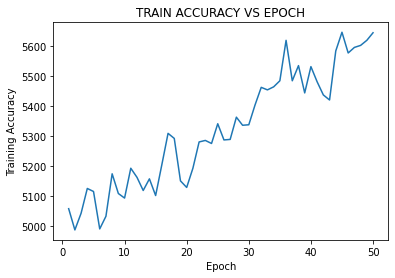

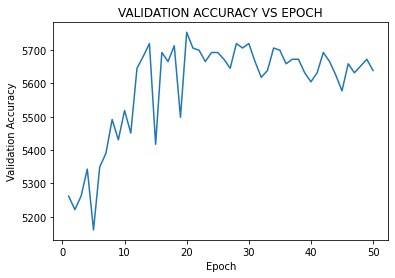

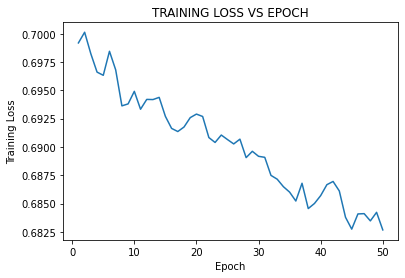

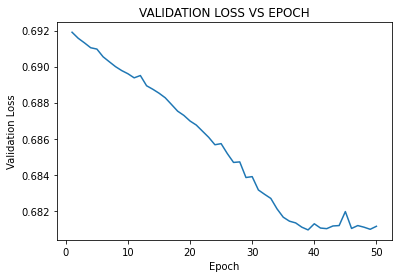

In [16]:
import matplotlib.pyplot as plt

plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.title("TRAIN ACCURACY VS EPOCH")
plt.plot(epoch_arr,train_accuracy_arr)
plt.show()

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("VALIDATION ACCURACY VS EPOCH")
plt.plot(epoch_arr,val_accuracy_arr)
plt.show()

plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("TRAINING LOSS VS EPOCH")
plt.plot(epoch_arr,train_loss_arr)
plt.show()

plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("VALIDATION LOSS VS EPOCH")
plt.plot(epoch_arr,val_loss_arr)
plt.show()

# **Model evaluation**

*ROC-AUC score and Classification report calculation*

In [17]:
# Concatenating true,predicted labels for both train and validation sets
def get_ytrue_ypred(actual_labels,predicted_labels):
    y_true=[]
    y_pred=[]
    for i in range(len(actual_labels)):
        try:
            predicted,pred_ind = torch.max(F.softmax(predicted_labels[i], dim=-1),1)
            for j in range(BATCH_SIZE):
                y_true.append(actual_labels[i][j])
                y_pred.append(pred_ind[j])
        except: # Handling last batch
            if predicted_labels[i].dim()==1: 
                predicted,pred_ind = torch.max(F.softmax(predicted_labels[i].reshape((1,2)), dim=-1),1)
                for j in range(1):
                    y_true.append(actual_labels[i][j])
                    y_pred.append(pred_ind[j])
            else:
                predicted,pred_ind = torch.max(F.softmax(predicted_labels[i].reshape((predicted_labels[i].shape[0],2)), dim=-1),1)
                for j in range(predicted_labels[i].shape[0]):
                    y_true.append(actual_labels[i][j])
                    y_pred.append(pred_ind[j])
    
    return y_true,y_pred

y_true,y_pred = get_ytrue_ypred(actual_labels_train,predicted_labels_train)
y_true_val,y_pred_val = get_ytrue_ypred(actual_labels_val,predicted_labels_val)

y_true.extend(y_true_val)
y_pred.extend(y_pred_val)

y_true = list(map(int,y_true))
y_pred = list(map(int,y_pred))

fpr, tpr, thresholds = metrics.roc_curve(y_true,y_pred)
auc = metrics.auc(fpr,tpr)
print("ROC-AUC score: ",auc)

cr = metrics.classification_report(y_true, y_pred)
print("Classification report")
print(cr)

ROC-AUC score:  0.5605517899447222
Classification report
              precision    recall  f1-score   support

           0       0.57      0.43      0.49      3600
           1       0.56      0.69      0.62      3799

    accuracy                           0.56      7399
   macro avg       0.57      0.56      0.55      7399
weighted avg       0.57      0.56      0.56      7399



*Storing predicted labels and urlids for test.tsv in csv file*

In [18]:
predicted_test_labels = []
model.eval()
with torch.no_grad():
    for batch in test_iter:
        input_tensor = torch.cat((batch.text,torch.transpose(batch.numerical,0,1)),dim=0)
        input_tensor = F.normalize(input_tensor.double(), p=2, dim=1)
        input_tensor = torch.add(input_tensor*25,25)
        predictions = model(input_tensor.long()).squeeze(0)
        try:
            predicted,pred_ind = torch.max(F.softmax(predictions, dim=-1),1)
            for j in range(BATCH_SIZE):
                predicted_test_labels.append(int(pred_ind[j]))
        except: # Handling last batch
            predicted,pred_ind = torch.max(F.softmax(predictions.reshape((len(test_data)%BATCH_SIZE,2)), dim=-1),1)
            for j in range(len(test_data)%BATCH_SIZE):
                predicted_test_labels.append(int(pred_ind[j]))

In [19]:
# Getting urlids, parsing test.tsv again
url_ids = []
with open(filename_test) as tsvfile:
    tsvreader = csv.reader(tsvfile, delimiter="\t")
    column_names = tsvreader.__next__()
    for row in tsvreader:
        url_ids.append(int(row[1]))

In [20]:
submission_file = "/content/gdrive/My Drive/Colab Notebooks/StumbleUpon Challenge/submission_file.csv"

test_submit_data = []
for j in range(len(predicted_test_labels)):
    test_submit_data.append([url_ids[j] , predicted_test_labels[j]])

with open(submission_file,"w") as submit:
    csvwriter=csv.writer(submit)
    csvwriter.writerow(['urlid','label'])
    csvwriter.writerows(test_submit_data)

**References**

For the model-

https://www.kaggle.com/kuldeep7688/simple-rnn-using-glove-embeddings-in-pytorch

Help in adding features, errors-

https://stackoverflow.com/questions/54267919/how-can-i-add-a-feature-using-torchtext

https://discuss.pytorch.org/t/cuda-error-runtimeerror-cudnn-status-execution-failed/17625

https://discuss.pytorch.org/t/runtimeerror-cuda-error-cublas-status-alloc-failed-when-calling-cublascreate-handle/78545/5